# Quest05: 네이버 영화리뷰 감성분석 도전하기!

### 평가문항에 맞춰서 작성
**1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**  
-> 3가지 이상의 모델이 성공적으로 시도됨(RNN,CNN,Transfer Learning)

**2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**  
-> gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함

**3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**  
-> 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

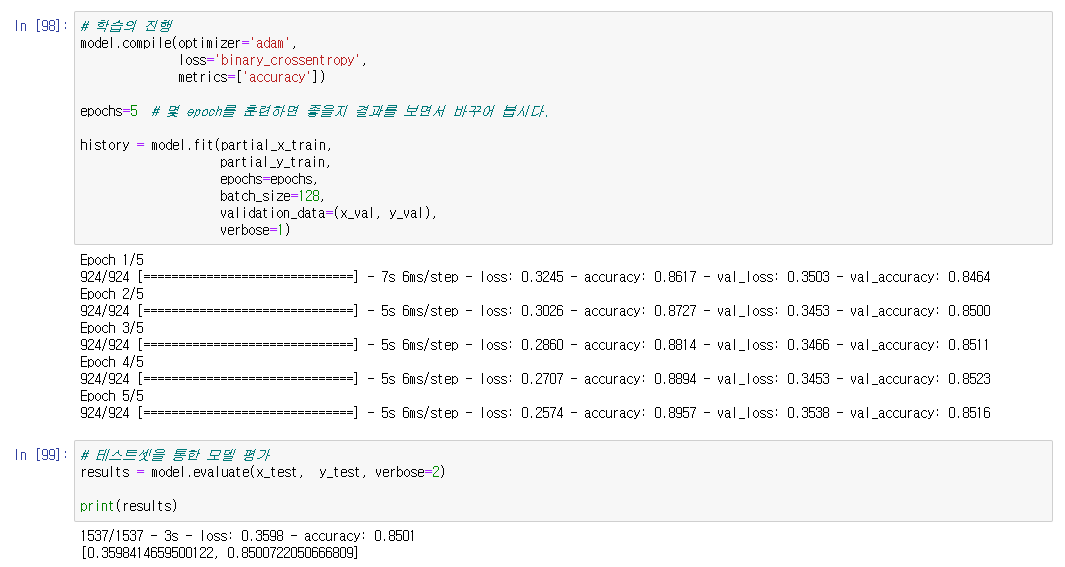

### 1) 데이터 준비와 확인

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1



---

### 2) 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train_data['document'] = train_data['document'].str.replace("[\,\.\`]","")
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    # test_data['document'] = test_data['document'].str.replace("[\,\.\`]","")
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### 2-1) X_train, y_train, X_test, y_test, word_to_index 데이터 확인

In [3]:
print("X_train: ", len(X_train)) # 문장 길이 temp_X = tokenizer.morphs(sentence) # 토큰화
print("y_train: ", len(y_train))
print("X_test: ", len(X_test))
print("y_test: ", len(y_test))

word_to_index = sorted(word_to_index.items(), key = lambda item: item[1])
word_to_index = dict(word_to_index)

X_train:  146182
y_train:  146182
X_test:  49157
y_test:  49157


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word) # 변환 <- 추가 필요 0,1,2 값이 없음

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105:

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


---

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


- 적절한 최대 문장 길이 지정

In [7]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
import tensorflow as tf
import os

vocab_size = len(word_to_index) # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

raw_inputs = np.array(X_train, dtype='object')
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)
output = embedding(raw_inputs)


---

### 4) 모델 구성 및 validation set 구성
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

## RNN & CNN 모델 구성

In [9]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다.
word_vector_dim = 300  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

# RNN

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(12))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

'''
#CNN 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

'''

#CNN 2
'''
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
'''

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 12)                15024     
_________________________________________________________________
dense (Dense)                (None, 8)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,015,137
Trainable params: 3,015,137
Non-trainable params: 0
_________________________________________________________________



---

### 5) 모델 훈련 개시

In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

In [11]:
# validation set 30000건 분리
x_val = x_train[:28000]
y_val = y_train[:28000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[28000:]  
partial_y_train = y_train[28000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(118182, 41)
(118182,)


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=7  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/7
462/462 [==============================] - 34s 8ms/step - loss: 0.4084 - accuracy: 0.8199 - val_loss: 0.3359 - val_accuracy: 0.8540
Epoch 2/7
462/462 [==============================] - 3s 7ms/step - loss: 0.3000 - accuracy: 0.8734 - val_loss: 0.3272 - val_accuracy: 0.8581
Epoch 3/7
462/462 [==============================] - 3s 7ms/step - loss: 0.2570 - accuracy: 0.8931 - val_loss: 0.3396 - val_accuracy: 0.8587
Epoch 4/7
462/462 [==============================] - 3s 7ms/step - loss: 0.2206 - accuracy: 0.9109 - val_loss: 0.3659 - val_accuracy: 0.8569
Epoch 5/7
462/462 [==============================] - 3s 7ms/step - loss: 0.1931 - accuracy: 0.9240 - val_loss: 0.3877 - val_accuracy: 0.8529
Epoch 6/7
462/462 [==============================] - 3s 7ms/step - loss: 0.1641 - accuracy: 0.9382 - val_loss: 0.4160 - val_accuracy: 0.8509
Epoch 7/7
462/462 [==============================] - 3s 7ms/step - loss: 0.1426 - accuracy: 0.9475 - val_loss: 0.4423 - val_accuracy: 0.8483


In [28]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3475 - accuracy: 0.8501
[0.34745389223098755, 0.8501332402229309]



---

### 6) Loss, Accuracy 그래프 시각화

In [14]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


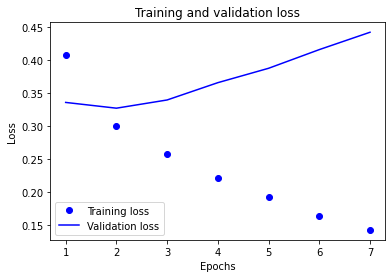

In [15]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

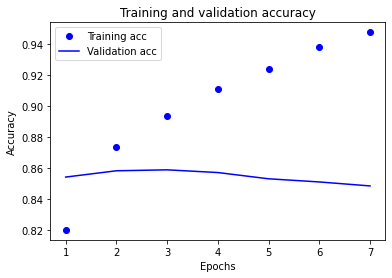

In [16]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


---

### 7) 학습된 Embedding 레이어 분석

In [17]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [18]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [19]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

array([ 1.45542864e-02,  1.22998521e-01,  3.77258174e-02, -4.61163931e-02,
        4.78815995e-02, -1.08033242e-02,  8.51481557e-02, -4.15489003e-02,
       -3.10863946e-02, -4.77854870e-02, -9.60614979e-02, -6.36870414e-02,
       -1.41566340e-02,  4.71136831e-02, -2.68216338e-02,  1.06880823e-02,
        3.56545784e-02,  5.28488494e-02, -3.40671949e-02,  7.58636445e-02,
        4.24941070e-03,  9.09025408e-03,  9.63776782e-02, -1.46268159e-02,
       -1.06446370e-02, -2.12133583e-02, -4.28506918e-02, -2.87397373e-02,
       -6.24421388e-02,  1.66439023e-02, -3.35823894e-02, -3.30402702e-02,
       -1.12882685e-02,  4.44165394e-02,  1.54925417e-03,  5.35822101e-02,
        6.94635790e-03,  1.21094445e-02, -8.67993906e-02, -3.36358622e-02,
       -3.40168439e-02,  2.13259086e-02,  9.27351192e-02,  3.70606929e-02,
        4.15114053e-02, -8.15577805e-02, -1.41537443e-01,  1.25192699e-03,
        3.68862748e-02,  7.50938728e-02, -7.80358016e-02, -1.04911320e-01,
       -9.45119783e-02, -

In [20]:
word_vectors.similar_by_word("잠")

[('제로', 0.8872255086898804),
 ('지루함', 0.8807527422904968),
 ('뻔해서', 0.8759397864341736),
 ('진부', 0.8739059567451477),
 ('쓰레기', 0.867900550365448),
 ('OOO', 0.8671941757202148),
 ('지루', 0.8671255111694336),
 ('걸까요', 0.8642697334289551),
 ('억지', 0.8627760410308838),
 ('고리타분', 0.8575572371482849)]


---

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.


**예시 코드**
from gensim.models.keyedvectors import Word2VecKeyedVectors  
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)  
vector = word_vectors.wv[‘끝’]

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME') + "/data/word2vec_ko.model"

word_vectors2 = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors2.wv["끝"]

In [22]:
word_vectors2.wv.similar_by_word("잠")

[('낮잠', 0.7209728956222534),
 ('깨어나', 0.6985119581222534),
 ('늦잠', 0.6658555865287781),
 ('한숨', 0.6528148055076599),
 ('하룻밤', 0.6330604553222656),
 ('노숙', 0.6213618516921997),
 ('도망가', 0.6158702373504639),
 ('깨어났', 0.613922655582428),
 ('겨울잠', 0.6007667779922485),
 ('감방', 0.5990805625915527)]

In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(5,vocab_size):
    if index_to_word[i] in word_vectors2.wv:
        embedding_matrix[i] = word_vectors2.wv[index_to_word[i]]

In [29]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [30]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=3  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/3
1847/1847 [==============================] - 12s 6ms/step - loss: 0.4179 - accuracy: 0.8050 - val_loss: 0.3415 - val_accuracy: 0.8499
Epoch 2/3
1847/1847 [==============================] - 10s 6ms/step - loss: 0.3134 - accuracy: 0.8649 - val_loss: 0.3261 - val_accuracy: 0.8581
Epoch 3/3
1847/1847 [==============================] - 10s 6ms/step - loss: 0.2755 - accuracy: 0.8835 - val_loss: 0.3199 - val_accuracy: 0.8630


In [31]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3287 - accuracy: 0.8599
[0.32869771122932434, 0.8598572015762329]


In [27]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 자체학습과 사전학습의 유사도 차이 분석

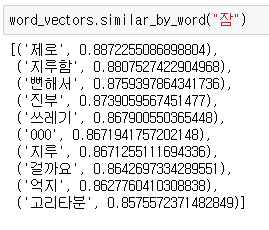  

위는 자체학습으로 진행한 유사도 측정인데 연관성이 별로 없는 것처럼 보인다.

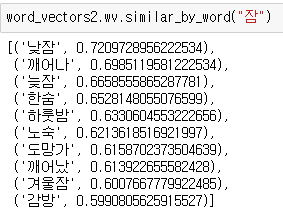  

사전학습으로 

회고
RNN, CNN, 전이학습을 사용한 